# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
#import mpl_toolkits.basemap as bm
from collections import Counter
from sklearn.manifold import TSNE
from IPython.core.display import display, HTML
from time import time
from sklearn import datasets
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.cluster.hierarchy import fcluster

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Задание 1

In [2]:
class Clustering(BaseEstimator, ClusterMixin):
    
    
    def __init__(self, X, k, linkage, **kwargs):
        self.X = X
        self.distance_matrix = self.init_distance_matrix() #Distance matrix
        self.linkage = linkage #linkage mode
        self.Z = np.zeros((1,4)) #outpot linkage matrix
        self.cluster_number = self.X.shape[0] - 1 #clusters' names
        self.labels_amount = np.array([range(self.X.shape[0]),np.ones(self.X.shape[0])]) #objects in each clusters
        self.k = k 
        
        
    def init_distance_matrix(self): 
        res = ss.distance.cdist(self.X, self.X)
        np.fill_diagonal(res,'inf')
        return res
    
    
    def update_distance_matrix(self, pair_to_unite):
        if self.linkage == 'average':
            self.distance_matrix[pair_to_unite[0]] = (self.distance_matrix[pair_to_unite[0]] * 
                                                      self.labels_amount[1][pair_to_unite[0]]  + 
                                                      self.distance_matrix[pair_to_unite[1]] * 
                                                      self.labels_amount[1][pair_to_unite[1]]) / ((self.labels_amount[1][pair_to_unite[0]] + 
                                                                                                   self.labels_amount[1][pair_to_unite[1]]))
        else:
            if self.linkage == 'single':
                self.distance_matrix[pair_to_unite[0]] = np.minimum(self.distance_matrix[pair_to_unite[0]],self.distance_matrix[pair_to_unite[1]])  
            else:
                if self.linkage == 'complete':
                    self.distance_matrix[pair_to_unite[0]] = np.maximum(self.distance_matrix[pair_to_unite[0]],self.distance_matrix[pair_to_unite[1]])                    
        self.distance_matrix[:,pair_to_unite[0]] = self.distance_matrix[pair_to_unite[0]]
        np.fill_diagonal(self.distance_matrix,'inf')
        self.distance_matrix = np.delete(self.distance_matrix, pair_to_unite[1], axis=0)
        self.distance_matrix = np.delete(self.distance_matrix, pair_to_unite[1], axis=1)
        
        
    def find_closest(self):
        argmin_ = np.argmin(self.distance_matrix)
        col = argmin_ % self.distance_matrix.shape[1]
        row = (argmin_ - col) / self.distance_matrix.shape[1]  
        return row, col
    
    
    def unite_sets(self, pair_to_unite):
        self.X = np.delete(self.X, pair_to_unite[1],axis=0)
        self.labels_amount = np.delete(self.labels_amount, pair_to_unite[1],axis=1)
        self.labels_amount[1][pair_to_unite[0]] += 1
        
        
    def fit(self):
        z_row_index = 0        
        cluster_amount = self.X.shape[0]
        self.cluster_names = range(cluster_amount)        
        while (self.X.shape[0] > 1): 
            pair_to_unite = self.find_closest() 
            z_row = np.array([self.cluster_names[pair_to_unite[0]], 
                              self.cluster_names[pair_to_unite[1]], 
                              self.distance_matrix[pair_to_unite[0]][pair_to_unite[1]], 
                              self.labels_amount[1][pair_to_unite[0]] + self.labels_amount[1][pair_to_unite[1]]])
            self.Z[z_row_index] = z_row
            self.Z = np.vstack((self.Z,np.zeros(4))) 
            z_row_index +=1 
            self.update_distance_matrix(pair_to_unite)            
            self.unite_sets(pair_to_unite) 
            self.cluster_number += 1
            self.cluster_names[pair_to_unite[0]] = self.cluster_number            
            del self.cluster_names[pair_to_unite[1]]          
        self.Z = np.delete(self.Z,self.Z.shape[0]-1,axis=0)        
        return self    
    
    def predict(self):
        self.labels = fcluster(self.Z,self.k,criterion='maxclust')
        return self.labels    
    
    def fit_predict(self):
        self.fit()
        return self.predict()         
        

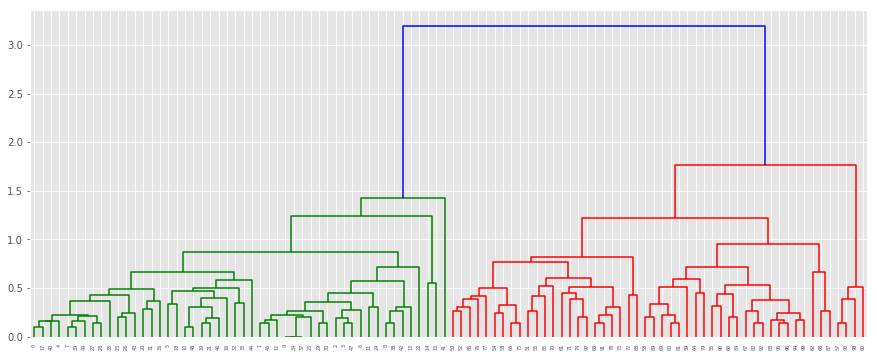

In [3]:
iris = datasets.load_iris()
x_iris = iris.data[:100]
model = Clustering(x_iris,2,linkage='average')
model.fit()
pl.figure(figsize=(15, 6))
dend = dendrogram(model.Z)

In [4]:
%%timeit
model = Clustering(x_iris,k=2,linkage='single')
model.fit()

100 loops, best of 3: 6.82 ms per loop


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

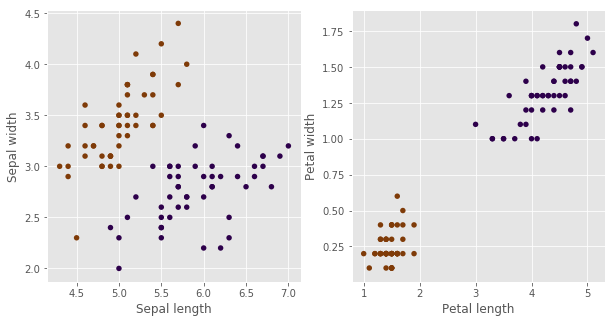

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
model = Clustering(x_iris,k=2,linkage='average')
y_iris = model.fit_predict() 


pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()



Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering(x_iris,k=2,linkage='single')
pred_iris = pred_iris.fit_predict()
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

## Задание 2
## Dunn Index

In [11]:
def quality(x, labels):
    deltas = []
    for i in labels:
        for j in labels:
            if i == j:
                continue
            dist = np.min(ss.distance.cdist(x[labels == i], x[labels == j]))
            deltas.insert(len(deltas), dist)
    diam = np.max([np.max(ss.distance.cdist(x[labels == l],x[labels == l])) for l in labels])
    return min(deltas) / diam

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Single linkage:   0.60414668396 num clusters:   2
Complete linkage:   0.60414668396 num clusters:   2
Average linkage:   0.60414668396 num clusters:   2


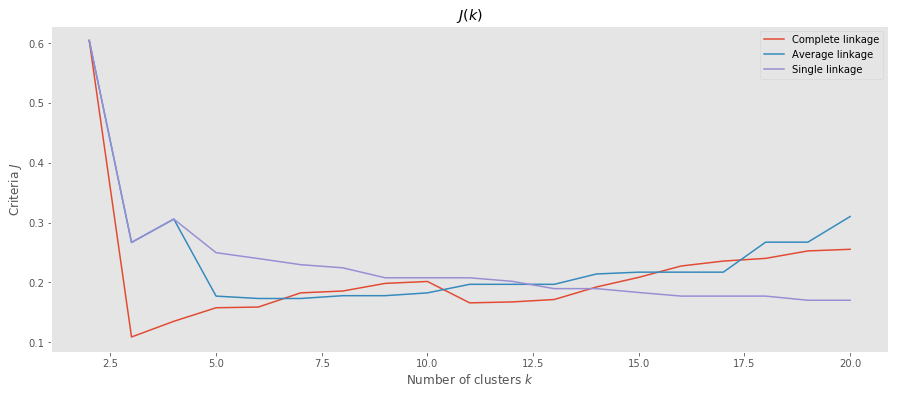

In [8]:
ks = range(2, 21)
criteria_single = np.zeros(len(ks))
criteria_complete = np.zeros(len(ks))
criteria_average = np.zeros(len(ks))

for i, k in enumerate(ks):
    
    cls = Clustering(x_iris,k,'single')
    y = cls.fit_predict()
    criteria_single[i] = quality(x_iris, y)
    
for i, k in enumerate(ks):
    cls = Clustering(x_iris,k,'complete')
    y = cls.fit_predict()
    criteria_complete[i] = quality(x_iris, y)
    
for i, k in enumerate(ks):
    cls = Clustering(x_iris,k,'average')
    y = cls.fit_predict()
    criteria_average[i] = quality(x_iris, y)

print 'Single linkage:  ', np.max(criteria_single), 'num clusters:  ', np.argmax(criteria_single) + 2 
print 'Complete linkage:  ', np.max(criteria_complete), 'num clusters:  ', np.argmax(criteria_complete) + 2 
print 'Average linkage:  ', np.max(criteria_average), 'num clusters:  ', np.argmax(criteria_average) + 2 

pl.figure(figsize=(15, 6))
pl.plot(ks, criteria_complete, label='Complete linkage')
pl.plot(ks, criteria_average, label='Average linkage')
pl.plot(ks, criteria_single, label='Single linkage')
pl.legend()
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()  


## Задание 3


In [9]:
df = pd.read_csv('WDIData.csv', sep=',')
df1 = df[['Country Name', 'Indicator Code', '2014']]
df1 = df1.set_index(['Country Name', 'Indicator Code'])
df1 = df1.unstack()
df1 = (df1 - df1.mean()) / df1.std()
df1 = df1['2014']
df1 = df1.fillna(0)
df1  = df1[df1.columns[(df1 ** 2).sum() > 200]]
df1.head()

Indicator Code,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,...,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.MRCH.XD.WD,TX.VAL.OTHR.ZS.WT,TX.VAL.SERV.CD.WT,TX.VAL.TRAN.ZS.WT,TX.VAL.TRVL.ZS.WT
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.244398,-0.277940,0.984492,0.045259,0.154960,-0.144930,-0.320210,-0.528283,-0.324077,-1.306529,...,0.024753,7.539205,-0.483611,-0.508685,-0.320471,-0.077847,1.842068,-0.292947,-0.994556,-1.446230
Albania,-0.158119,-0.341493,0.246753,-0.303610,0.051760,0.679789,-0.354140,-0.146916,-0.325253,-0.145478,...,-0.219734,-0.093488,-0.474542,-0.476925,-0.319689,0.506464,-0.527350,-0.290899,-0.967720,1.282435
Algeria,-0.199734,-0.271848,-0.988223,0.030554,-0.042723,-0.829342,-0.329065,-0.501059,-0.322858,-1.362073,...,0.405917,-0.475251,-0.502542,-0.476685,-0.292621,-0.225683,1.379256,-0.289308,0.109299,-1.438712
American Samoa,0.000000,-0.343517,-0.643625,-0.333478,-0.627588,0.096845,0.000000,0.773176,-0.326791,2.508161,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.425402,0.000000,0.000000,0.000000,0.000000
Andorra,0.000000,-0.343489,0.324881,-0.333488,-0.707814,-0.609086,0.000000,0.000000,-0.326794,0.114543,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.312460,0.000000,0.000000,0.000000,0.000000


In [12]:
model = Clustering(df1.values,k=8,linkage='average')
model.fit()
labels = model.predict()

In [13]:
for i in xrange(1,8):
    print 'cluster №', i
    print list(df1.iloc[labels == i].index)
    print '==========='

cluster № 1
['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Fragile and conflict affected situations', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Heavily indebted poor countries (HIPC)', 'IDA blend', 'IDA only', 'IDA total', 'Iraq', 'Kenya', 'Kiribati', 'Least developed countries: UN classification', 'Lesotho', 'Low income', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Papua New Guinea', 'Pre-demographic dividend', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)', 'Sudan', 'Swaziland', 'Syrian Arab Republic', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'West Ban

In [14]:
X_embedded = TSNE(n_components=2).fit_transform(df1.values)

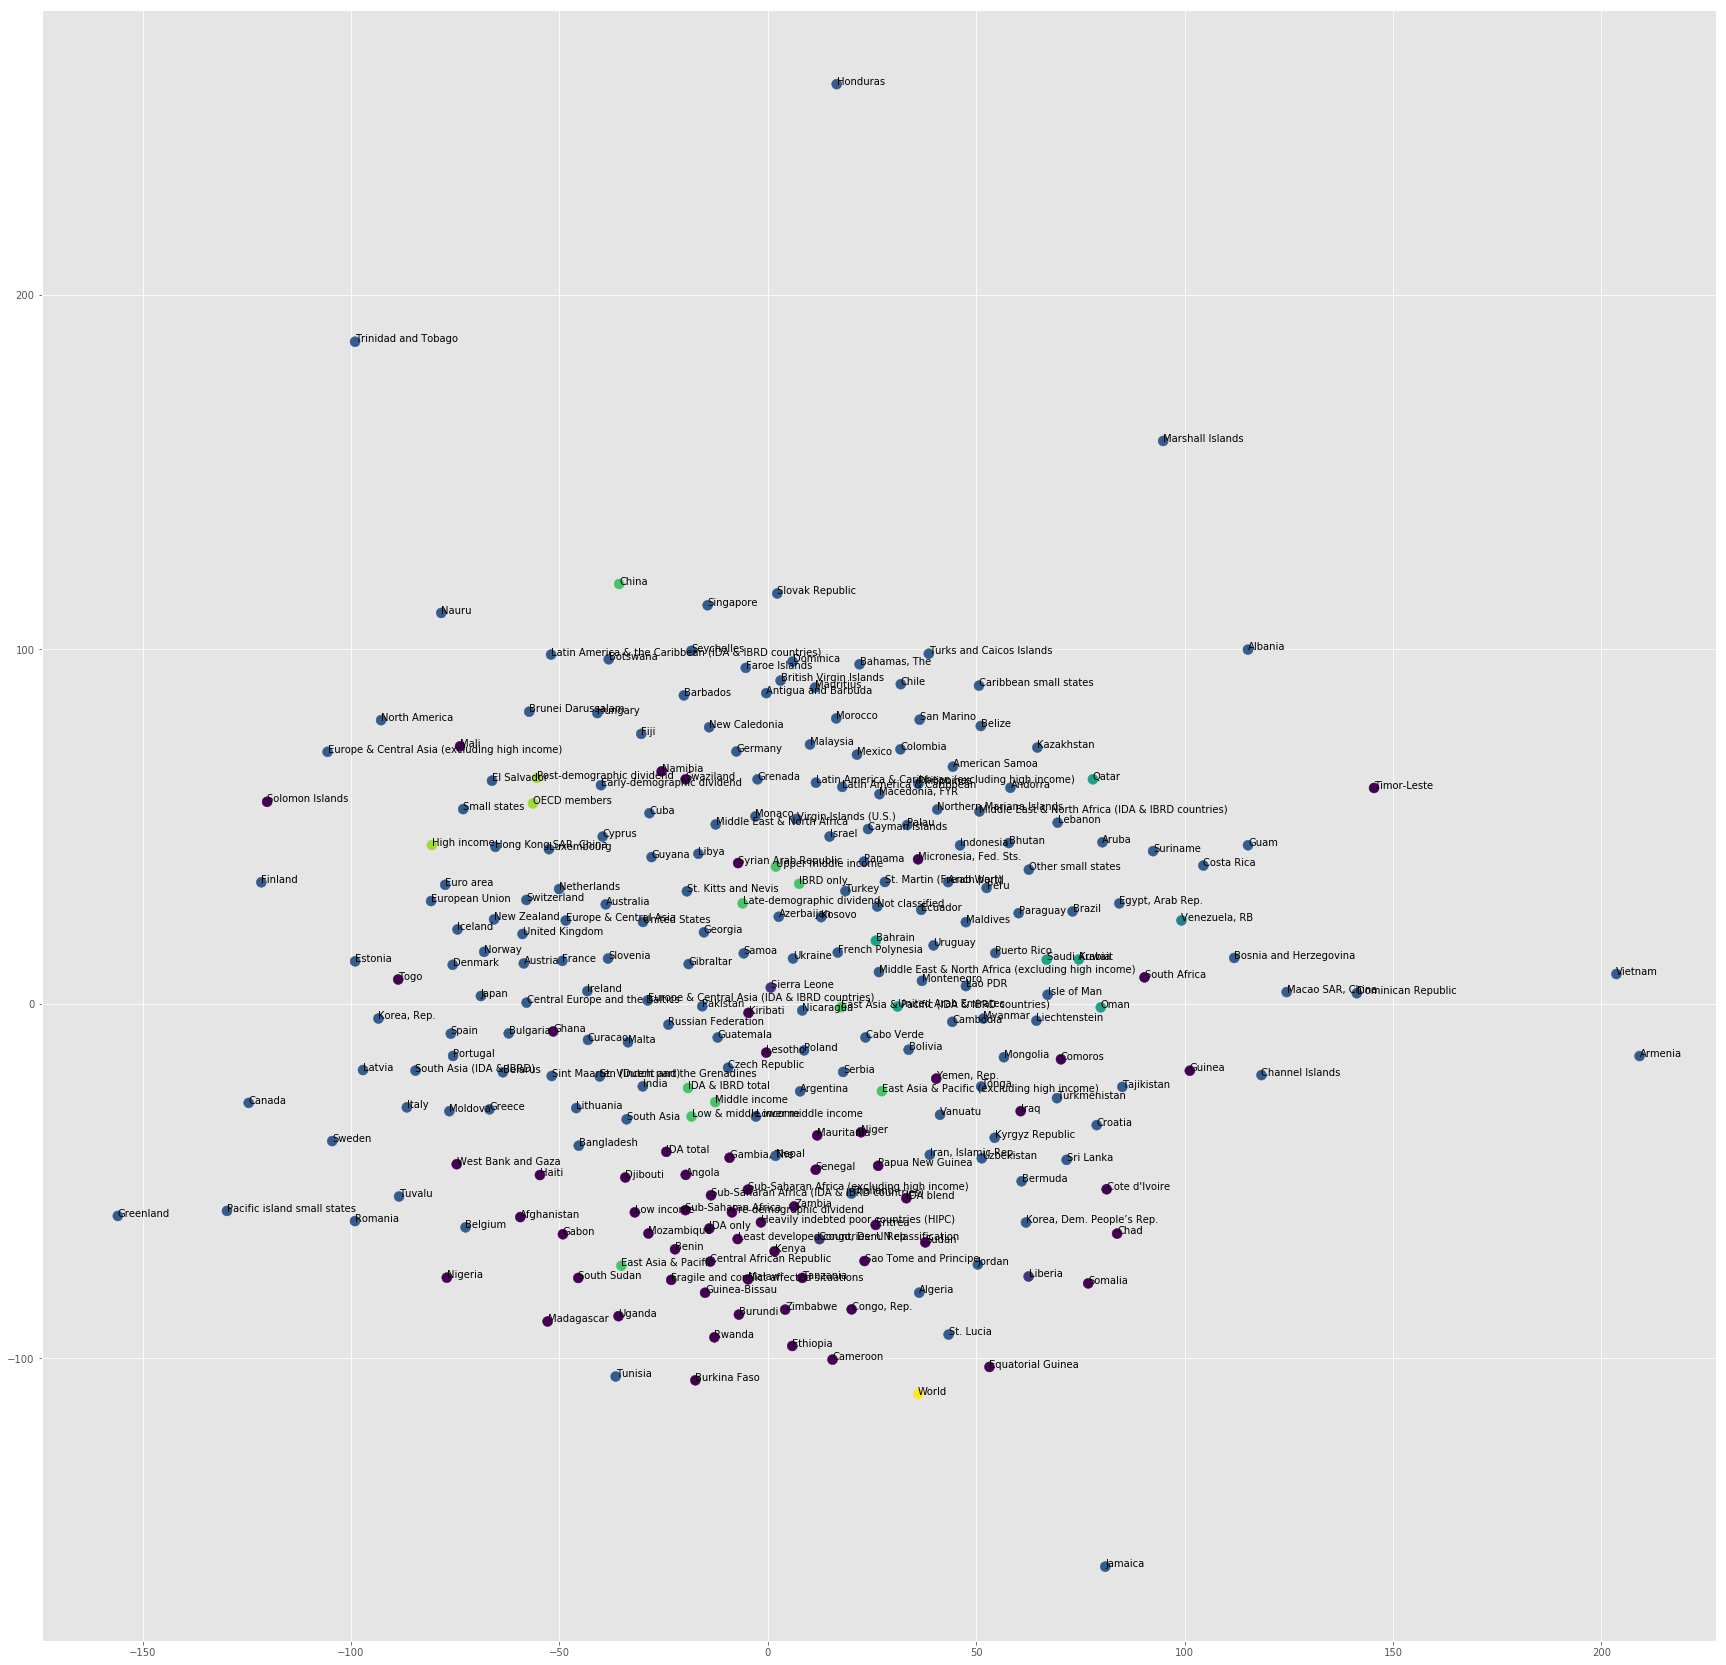

In [16]:
import sys
reload(sys)
sys.setdefaultencoding('UTF8')
plt.figure()
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30,30)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels,  s=100)
for i in xrange(df1.shape[0]):
    plt.annotate((df1.index[i]), xy = X_embedded[i])
plt.show()

## Задание 4
Разделение произошло по большей мере по политическим и географическим признакам, а также явно прослеживается кластер со странами третьего мира


Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.